# Light GBM
- Light GBM, XGBoost'un eğitim süresi performansını arttırmaya yönelik geliştirilen bir diğer GBM türüdür.
- Daha performanslıdır.
- karar ağaçlarına (Desicion Tree) dayanmaktadır.
- Level-wise büyüme stratejisi yerine Leaf-wise büyüme stratejisidir.
- XGBoost Breadth-first search (BFS, Geniş Kapsamlı İlk Arama) algoritmasını yapar, Light GBM ise yerine depth-first search(DFS, Derinlemesine İlk Arama) algoritmasını yapar.

In [1]:
!pip install lightgbm

**Gerekli Kütüphaneler** 

In [2]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, mean_squared_error, r2_score, roc_auc_score, roc_curve, classification_report
from sklearn.preprocessing import scale, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from lightgbm import LGBMClassifier

<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject


In [3]:
# Uyarı Mesajları ile Karşılaşmamak için bu kütüphaneyi kullanıyoruz.
from warnings import filterwarnings
filterwarnings("ignore", category=DeprecationWarning)
filterwarnings("ignore", category=FutureWarning)

# Veri Seti Hikayesi ve Problemi: Şeker Hastalığı Tahmini

In [4]:
df = pd.read_csv("./diabetes.csv")
# bu csv dosyasının içerisinde eksik gözlemleri(NA) çıkardık.
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


# Light GBM ve Tahmin İşlemleri

In [5]:
y= df["Outcome"]
X = df.drop(["Outcome"], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.30,
                                                    random_state = 42)

**Model**

In [6]:
light_model = LGBMClassifier().fit(X_train,y_train)

In [7]:
?light_model

Type:           LGBMClassifier
String form:    LGBMClassifier()
File:           c:\users\halil\anaconda3\lib\site-packages\lightgbm\sklearn.py
Docstring:      LightGBM classifier.
Init docstring:
Construct a gradient boosting model.

Parameters
----------
boosting_type : string, optional (default='gbdt')
    'gbdt', traditional Gradient Boosting Decision Tree.
    'dart', Dropouts meet Multiple Additive Regression Trees.
    'goss', Gradient-based One-Side Sampling.
    'rf', Random Forest.
num_leaves : int, optional (default=31)
    Maximum tree leaves for base learners.
max_depth : int, optional (default=-1)
    Maximum tree depth for base learners, <=0 means no limit.
learning_rate : float, optional (default=0.1)
    Boosting learning rate.
    You can use ``callbacks`` parameter of ``fit`` method to shrink/adapt learning rate
    in training using ``reset_parameter`` callback.
    Note, that this will ignore the ``learning_rate`` argument in training.
n_estimators : int, optional (

In [8]:
y_pred = light_model.predict(X_test)

In [9]:
accuracy_score(y_test,y_pred)

0.7229437229437229

# Model Tuning (Model Doğrulama)
-  Modelin başarısını değerlendirmek için izlenecek yol Doğruluk oranına (accuracy_score) bakılarak yapılacak. 
- **accuracy_score**' u ne kadar büyük olursa sınıflandırma da o kadar başarılı olduğu anlamına gelir.
- Hiper parametrelerin optimum değerlerine ulaşmak içinde Cross-Validation yöntemini kullanmış olacağız.
- Yani modelleri Train Setiyle eğitirken Cross-Validation yönetemini kullanıp, dışarı bıraktığımız Test Setini ise performansımızı test etmek için kullanacaz.

In [10]:
light_params = {"learning_rate": [0.01,0.001,0.1],
               "n_estimators": [100,200,500,1000],
                "max_depth":[1,2,35,8]}

In [11]:
light_cv_model = GridSearchCV(light_model,light_params, cv=10, n_jobs=-1, verbose=2).fit(X_train,y_train)

Fitting 10 folds for each of 48 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 297 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed:   15.4s finished


In [12]:
light_cv_model.best_params_

{'learning_rate': 0.01, 'max_depth': 1, 'n_estimators': 500}

**Final Modeli**

In [13]:
light_tuned = LGBMClassifier(learning_rate=0.01,
                            max_depth=1,
                            n_estimators=500).fit(X_train,y_train)

In [14]:
y_tuned_pred = light_tuned.predict(X_test)


In [15]:
accuracy_score(y_test,y_tuned_pred)

0.7575757575757576

## Değişken Önem Düzeyleri

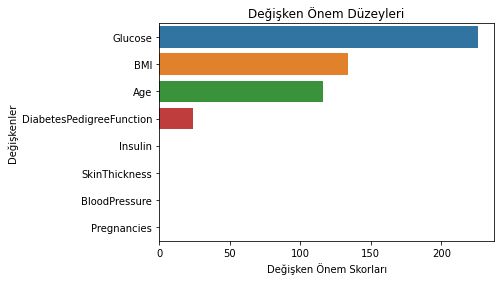

In [19]:
feature_imp = pd.Series(light_tuned.feature_importances_,
                        index=X_train.columns).sort_values(ascending=False)

sns.barplot(x=feature_imp, y=feature_imp.index)
plt.xlabel("Değişken Önem Skorları")
plt.ylabel("Değişkenler")
plt.title("Değişken Önem Düzeyleri")
plt.savefig("Değişken Önem Düzeyleri")
plt.show()